5-Fold Cross-Validation Accuracy Scores: [0.92424242 0.91184573 0.91724138 0.92413793 0.91172414]
Mean Cross-Validation Accuracy: 0.9178383205091668

Accuracy on test data: 0.9327453142227122

Classification Report:
               precision    recall  f1-score   support

     Level 1       1.00      1.00      1.00       191
    Level 10       1.00      1.00      1.00        16
     Level 2       1.00      1.00      1.00       124
     Level 3       1.00      0.89      0.94        28
     Level 4       0.94      0.95      0.94        80
     Level 5       0.86      0.76      0.81        58
     Level 6       0.65      0.82      0.73        44
     Level 7       0.92      0.85      0.88       156
     Level 8       0.89      0.94      0.91       139
     Level 9       0.97      1.00      0.99        71

    accuracy                           0.93       907
   macro avg       0.92      0.92      0.92       907
weighted avg       0.94      0.93      0.93       907



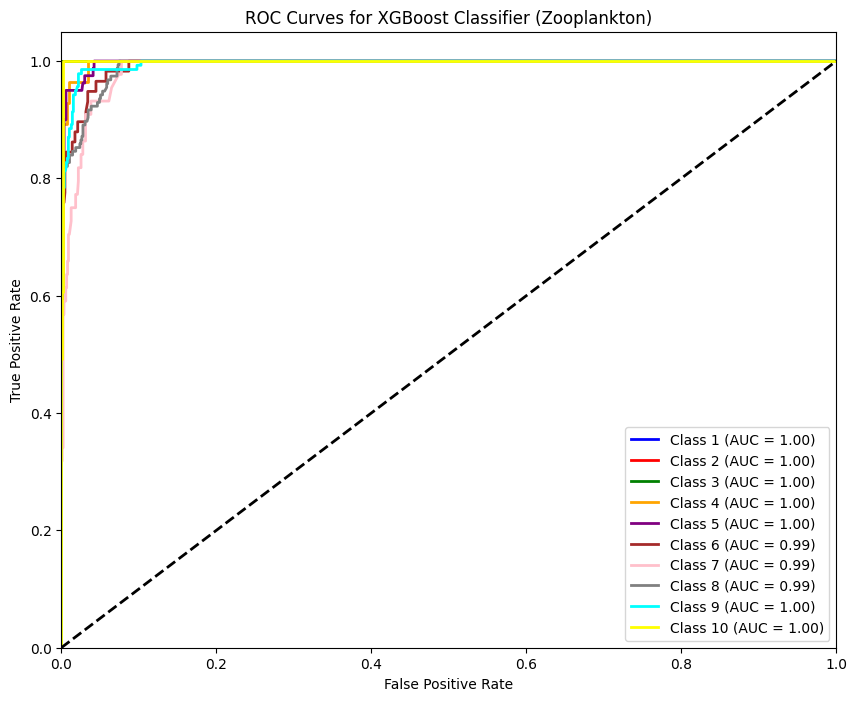

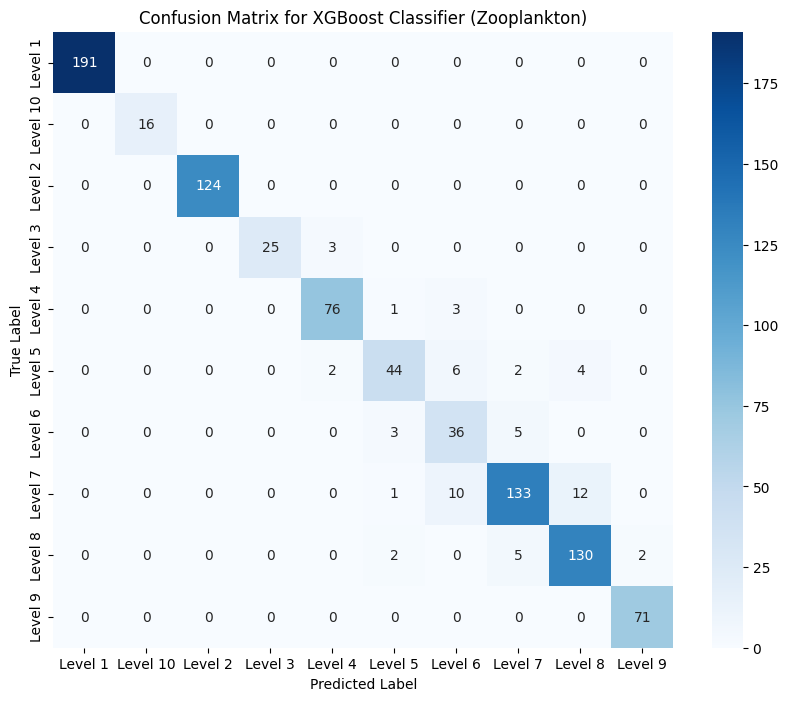

In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv('6639leveling.csv')

# Features (Temp, pH, TDS, Turbidity, DO)
X = data[['Temp', 'pH', 'TDS', 'Turbidity', 'DO']]

# Target labels (Phytoplankton)
y = data['Zooplankton']

# Encoding the text labels into numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the XGBoost Classifier
xgb_clf = XGBClassifier(objective='multi:softprob', num_class=len(label_encoder.classes_), n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# 5-fold Cross-validation accuracy scores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_clf, X_train, y_train, cv=cv, scoring='accuracy')

print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cv_scores))

# Train the model
xgb_clf.fit(X_train, y_train)

# Make predictions
y_pred = xgb_clf.predict(X_test)

# Evaluate the model
print("\nAccuracy on test data:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Compute ROC curve and ROC area for each class
n_classes = len(label_encoder.classes_)

# Binarize the output for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))
y_score = xgb_clf.predict_proba(X_test)  # Get predicted probabilities

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Handle case where class is missing in y_test by skipping those classes
    if len(np.unique(y_test_binarized[:, i])) > 1:
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        print(f"Class {i+1} is not present in the test set and will be skipped.")

# Plot the ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'yellow']  # Adjust colors for up to 10 classes
for i, color in zip(range(n_classes), colors):
    if i in fpr:  # Only plot the classes that were included
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost Classifier (Zooplankton)')
plt.legend(loc="lower right")
plt.show()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for XGBoost Classifier (Zooplankton)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
